# Timeseries classification using Conv1D layers

**Author:** [hfawaz](https://github.com/hfawaz/)<br>
**Date created:** 2020/07/21<br>
**Last modified:** 2020/08/21<br>
**Description:** Training a timeseries classifier from scratch on the FordA dataset from the UCR/UEA archive.

## Introduction

This example shows how to do timeseries classification from scratch, starting from raw
CSV timeseries files on disk. We demonstrate the workflow on the FordA dataset from the
[UCR/UEA archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/).

## Setup

In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).

### Read the TSV data

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use ConvNets for timeseries classification.
In this file, the first column corresponds to the label.

In [2]:

def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

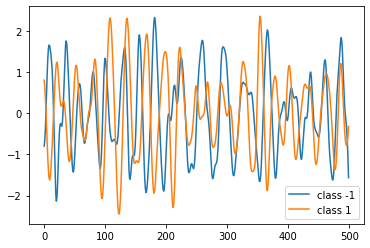

In [3]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Standardize the data

Our timeseries are already in a single length (176). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.

In [4]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [5]:
num_classes = len(np.unique(y_train))

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [6]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [7]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

## Build a model

We build a Fully Convolutional Neural Network originally proposed in
[this paper](https://arxiv.org/abs/1611.06455).
The implementation is based on the TF 2 version provided
[here](https://github.com/hfawaz/dl-4-tsc/).
The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found
via random search using [KerasTuner](https://github.com/keras-team/keras-tuner).

In [8]:

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 64)           256       
_________________________________________________________________
batch_normalization (BatchNo (None, 500, 64)           256       
_________________________________________________________________
re_lu (ReLU)                 (None, 500, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 64)           12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 500, 64)           256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 500, 64)           0     

## Train the model

In [10]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 [==============================] - 5s 44ms/step - loss: 0.6581 - sparse_categorical_accuracy: 0.6073 - val_loss: 0.8526 - val_sparse_categorical_accuracy: 0.4771
Epoch 2/500
90/90 [==============================] - 4s 41ms/step - loss: 0.4809 - sparse_categorical_accuracy: 0.7656 - val_loss: 0.9699 - val_sparse_categorical_accuracy: 0.4771
Epoch 3/500
90/90 [==============================] - 4s 43ms/step - loss: 0.4451 - sparse_categorical_accuracy: 0.7764 - val_loss: 0.8889 - val_sparse_categorical_accuracy: 0.4771
Epoch 4/500
90/90 [==============================] - 4s 43ms/step - loss: 0.4274 - sparse_categorical_accuracy: 0.7807 - val_loss: 0.8701 - val_sparse_categorical_accuracy: 0.4771
Epoch 5/500
90/90 [==============================] - 4s 44ms/step - loss: 0.4112 - sparse_categorical_accuracy: 0.8065 - val_loss: 0.4877 - val_sparse_categorical_accuracy: 0.8086
Epoch 6/500
90/90 [==============================] - 4s 44ms/step - loss: 0.4087 - sparse_categorica

90/90 [==============================] - 5s 52ms/step - loss: 0.2825 - sparse_categorical_accuracy: 0.8802 - val_loss: 0.2285 - val_sparse_categorical_accuracy: 0.9001
Epoch 47/500
90/90 [==============================] - 5s 51ms/step - loss: 0.2402 - sparse_categorical_accuracy: 0.9051 - val_loss: 0.2468 - val_sparse_categorical_accuracy: 0.9209
Epoch 48/500
90/90 [==============================] - 5s 54ms/step - loss: 0.2523 - sparse_categorical_accuracy: 0.8968 - val_loss: 0.2382 - val_sparse_categorical_accuracy: 0.9196
Epoch 49/500
90/90 [==============================] - 5s 54ms/step - loss: 0.2445 - sparse_categorical_accuracy: 0.8993 - val_loss: 0.3385 - val_sparse_categorical_accuracy: 0.8280
Epoch 50/500
90/90 [==============================] - 5s 57ms/step - loss: 0.2529 - sparse_categorical_accuracy: 0.8935 - val_loss: 0.6713 - val_sparse_categorical_accuracy: 0.6297
Epoch 51/500
90/90 [==============================] - 5s 58ms/step - loss: 0.2440 - sparse_categorical_accur

90/90 [==============================] - 4s 50ms/step - loss: 0.0990 - sparse_categorical_accuracy: 0.9692 - val_loss: 0.1913 - val_sparse_categorical_accuracy: 0.9307
Epoch 92/500
90/90 [==============================] - 5s 50ms/step - loss: 0.1156 - sparse_categorical_accuracy: 0.9645 - val_loss: 0.5360 - val_sparse_categorical_accuracy: 0.8044
Epoch 93/500
90/90 [==============================] - 5s 51ms/step - loss: 0.1217 - sparse_categorical_accuracy: 0.9539 - val_loss: 0.2318 - val_sparse_categorical_accuracy: 0.8890
Epoch 94/500
90/90 [==============================] - 5s 53ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.9593 - val_loss: 0.4044 - val_sparse_categorical_accuracy: 0.8031
Epoch 95/500
90/90 [==============================] - 5s 54ms/step - loss: 0.1166 - sparse_categorical_accuracy: 0.9586 - val_loss: 0.1442 - val_sparse_categorical_accuracy: 0.9556
Epoch 96/500
90/90 [==============================] - 5s 56ms/step - loss: 0.1179 - sparse_categorical_accur

90/90 [==============================] - 5s 56ms/step - loss: 0.0903 - sparse_categorical_accuracy: 0.9740 - val_loss: 0.1335 - val_sparse_categorical_accuracy: 0.9473
Epoch 137/500
90/90 [==============================] - 5s 55ms/step - loss: 0.0922 - sparse_categorical_accuracy: 0.9710 - val_loss: 0.1264 - val_sparse_categorical_accuracy: 0.9487
Epoch 138/500
90/90 [==============================] - 5s 57ms/step - loss: 0.0874 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.2246 - val_sparse_categorical_accuracy: 0.8960
Epoch 139/500
90/90 [==============================] - 5s 55ms/step - loss: 0.0959 - sparse_categorical_accuracy: 0.9658 - val_loss: 0.0872 - val_sparse_categorical_accuracy: 0.9695
Epoch 140/500
90/90 [==============================] - 5s 51ms/step - loss: 0.0780 - sparse_categorical_accuracy: 0.9728 - val_loss: 0.1030 - val_sparse_categorical_accuracy: 0.9681
Epoch 141/500
90/90 [==============================] - 4s 50ms/step - loss: 0.0778 - sparse_categorical_

90/90 [==============================] - 5s 61ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.1753 - val_sparse_categorical_accuracy: 0.9320
Epoch 182/500
90/90 [==============================] - 6s 62ms/step - loss: 0.0807 - sparse_categorical_accuracy: 0.9693 - val_loss: 0.2627 - val_sparse_categorical_accuracy: 0.9029
Epoch 183/500
90/90 [==============================] - 5s 61ms/step - loss: 0.0637 - sparse_categorical_accuracy: 0.9795 - val_loss: 0.1016 - val_sparse_categorical_accuracy: 0.9598
Epoch 184/500
90/90 [==============================] - 5s 61ms/step - loss: 0.0658 - sparse_categorical_accuracy: 0.9801 - val_loss: 0.0895 - val_sparse_categorical_accuracy: 0.9626
Epoch 185/500
90/90 [==============================] - 5s 58ms/step - loss: 0.0707 - sparse_categorical_accuracy: 0.9768 - val_loss: 0.0909 - val_sparse_categorical_accuracy: 0.9626
Epoch 186/500
90/90 [==============================] - 5s 57ms/step - loss: 0.0756 - sparse_categorical_

90/90 [==============================] - 5s 56ms/step - loss: 0.0558 - sparse_categorical_accuracy: 0.9817 - val_loss: 0.0770 - val_sparse_categorical_accuracy: 0.9709
Epoch 227/500
90/90 [==============================] - 5s 60ms/step - loss: 0.0488 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.0783 - val_sparse_categorical_accuracy: 0.9695
Epoch 228/500
90/90 [==============================] - 5s 55ms/step - loss: 0.0689 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.0848 - val_sparse_categorical_accuracy: 0.9681
Epoch 229/500
90/90 [==============================] - 5s 54ms/step - loss: 0.0504 - sparse_categorical_accuracy: 0.9847 - val_loss: 0.1253 - val_sparse_categorical_accuracy: 0.9542
Epoch 230/500
90/90 [==============================] - 5s 50ms/step - loss: 0.0555 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.0808 - val_sparse_categorical_accuracy: 0.9736
Epoch 231/500
90/90 [==============================] - 5s 52ms/step - loss: 0.0542 - sparse_categorical_

90/90 [==============================] - 5s 56ms/step - loss: 0.0497 - sparse_categorical_accuracy: 0.9847 - val_loss: 0.0869 - val_sparse_categorical_accuracy: 0.9639
Epoch 272/500
90/90 [==============================] - 5s 56ms/step - loss: 0.0517 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.0725 - val_sparse_categorical_accuracy: 0.9750
Epoch 273/500
90/90 [==============================] - 5s 52ms/step - loss: 0.0493 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.0799 - val_sparse_categorical_accuracy: 0.9639
Epoch 274/500
90/90 [==============================] - 5s 50ms/step - loss: 0.0473 - sparse_categorical_accuracy: 0.9848 - val_loss: 0.0895 - val_sparse_categorical_accuracy: 0.9653
Epoch 275/500
90/90 [==============================] - 5s 51ms/step - loss: 0.0560 - sparse_categorical_accuracy: 0.9808 - val_loss: 0.0783 - val_sparse_categorical_accuracy: 0.9764
Epoch 276/500
90/90 [==============================] - 5s 54ms/step - loss: 0.0600 - sparse_categorical_

90/90 [==============================] - 5s 58ms/step - loss: 0.0451 - sparse_categorical_accuracy: 0.9869 - val_loss: 0.0767 - val_sparse_categorical_accuracy: 0.9723
Epoch 317/500
90/90 [==============================] - 5s 61ms/step - loss: 0.0573 - sparse_categorical_accuracy: 0.9822 - val_loss: 0.0745 - val_sparse_categorical_accuracy: 0.9736
Epoch 318/500
90/90 [==============================] - 5s 59ms/step - loss: 0.0480 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.0730 - val_sparse_categorical_accuracy: 0.9736
Epoch 319/500
90/90 [==============================] - 5s 56ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9854 - val_loss: 0.0761 - val_sparse_categorical_accuracy: 0.9723
Epoch 320/500
90/90 [==============================] - 5s 57ms/step - loss: 0.0461 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.0784 - val_sparse_categorical_accuracy: 0.9736
Epoch 321/500
90/90 [==============================] - 5s 57ms/step - loss: 0.0442 - sparse_categorical_

90/90 [==============================] - 5s 59ms/step - loss: 0.0486 - sparse_categorical_accuracy: 0.9851 - val_loss: 0.0783 - val_sparse_categorical_accuracy: 0.9695
Epoch 362/500
90/90 [==============================] - 5s 60ms/step - loss: 0.0484 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.0790 - val_sparse_categorical_accuracy: 0.9667
Epoch 363/500
90/90 [==============================] - 5s 56ms/step - loss: 0.0505 - sparse_categorical_accuracy: 0.9820 - val_loss: 0.0750 - val_sparse_categorical_accuracy: 0.9723
Epoch 364/500
90/90 [==============================] - 5s 56ms/step - loss: 0.0456 - sparse_categorical_accuracy: 0.9874 - val_loss: 0.0731 - val_sparse_categorical_accuracy: 0.9764
Epoch 365/500
90/90 [==============================] - 5s 53ms/step - loss: 0.0464 - sparse_categorical_accuracy: 0.9876 - val_loss: 0.0743 - val_sparse_categorical_accuracy: 0.9723
Epoch 366/500
90/90 [==============================] - 5s 54ms/step - loss: 0.0497 - sparse_categorical_

## Evaluate model on test data

In [11]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 1s 10ms/step - loss: 0.0925 - sparse_categorical_accuracy: 0.9697
Test accuracy 0.9696969985961914
Test loss 0.09252453595399857


## Plot the model's training and validation loss

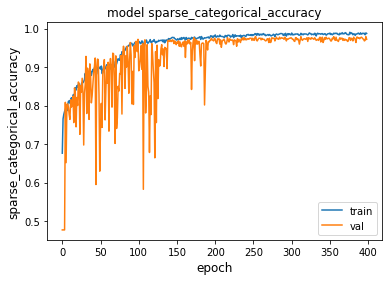

In [12]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

We can see how the training accuracy reaches almost 0.95 after 100 epochs.
However, by observing the validation accuracy we can see how the network still needs
training until it reaches almost 0.97 for both the validation and the training accuracy
after 200 epochs. Beyond the 200th epoch, if we continue on training, the validation
accuracy will start decreasing while the training accuracy will continue on increasing:
the model starts overfitting.